In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census
from us import states
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
import plotly.plotly as py
import plotly
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import glob

# Load Data

In [2]:
sfactors = pd.read_csv('socialfactors.csv',index_col=0,skiprows=1).values.ravel()
bfactors = pd.read_csv('behaviorfactors.csv',index_col=0,skiprows=1).values.ravel()
factors = np.append(sfactors, bfactors)
factors = np.append(factors, ['fips'])

In [3]:
def get_data(xlsfile):
    year = xlsfile.split(' County')[0][14:]
    
    dfd = pd.read_excel(xlsfile, sheet_name=3,index_col=[0,1],header=[0,1])
    dfd.rename(columns = {'Unnamed: 2_level_0':'Location'}, level=0,inplace=True)
    dfd['Location','fips'] = dfd.index.get_level_values(0).tolist()
    dfd.rename(index={'Illinois':'Illinois_'+year},inplace=True)
    dfd.columns = dfd.columns.droplevel()
    y = dfd['Years of Potential Life Lost Rate'].values.tolist()[1:]
    dfd = dfd.loc[:,[factor for factor in factors if factor in dfd.columns.tolist()]].iloc[1:] # remove first row (general illinois)

    dfd2 = pd.read_excel(xlsfile, sheet_name=5,index_col=[0,1],header=[0,1])
    dfd2.rename(columns = {'Unnamed: 2_level_0':'Location'}, level=0,inplace=True)
    dfd2['Location','fips'] = dfd2.index.get_level_values(0).tolist()
    
    dfd2.rename(index={'Illinois':'Illinois_'+year},inplace=True)
    dfd2.columns = dfd2.columns.droplevel()
    dfd2 = dfd2.loc[:,[factor for factor in factors if factor in dfd2.columns.tolist()]].iloc[1:] # remove first row (general illinois)
    print(year)
    if year =='2018':
        print('worked')
        return pd.concat(
            [dfd.set_index('fips'),dfd2.set_index('fips')]
            ,axis=1)[:-1], y[:-1]

    else:
#         return dfd, dfd2
        return pd.concat(
            [dfd.set_index('fips'),dfd2.set_index('fips')]
            ,axis=1
        ), y
    
    

In [5]:
xlsfiles = glob.glob('./*.xls')
dflist = []
df, y = get_data(xlsfiles[0])

print(xlsfiles)
for xlsfile in xlsfiles[1:]:
    print(xlsfile)
    tempdf, tempy = get_data(xlsfile)
    print(len(tempdf))
    cols = list(set(df.columns.tolist()) & set(tempdf.columns.tolist()))
    df = pd.merge(
        df.iloc[:,~df.columns.duplicated()][cols].reset_index(),
        tempdf.iloc[:,~tempdf.columns.duplicated()][cols].reset_index(),
        how='outer', 
    ).set_index('fips')
    y = y+tempy
    
y = np.asarray(y)

X = df.fillna(df.mean())#df.T.fillna(df.T.mean()).T
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]
fips = df.index.values
# df.drop(columns=['fips'],inplace=True)


2017
['./US_rankings/2017 County Health Rankings Data.xls', './US_rankings/2018 County Health Rankings Data - v2.xls', './US_rankings/2019 County Health Rankings Data - v2.xls']
./US_rankings/2018 County Health Rankings Data - v2.xls
2018
worked
3141
./US_rankings/2019 County Health Rankings Data - v2.xls
2019
3141


# Split and take a look

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)


Text(0.5, 1.0, 'Correlation matrix')

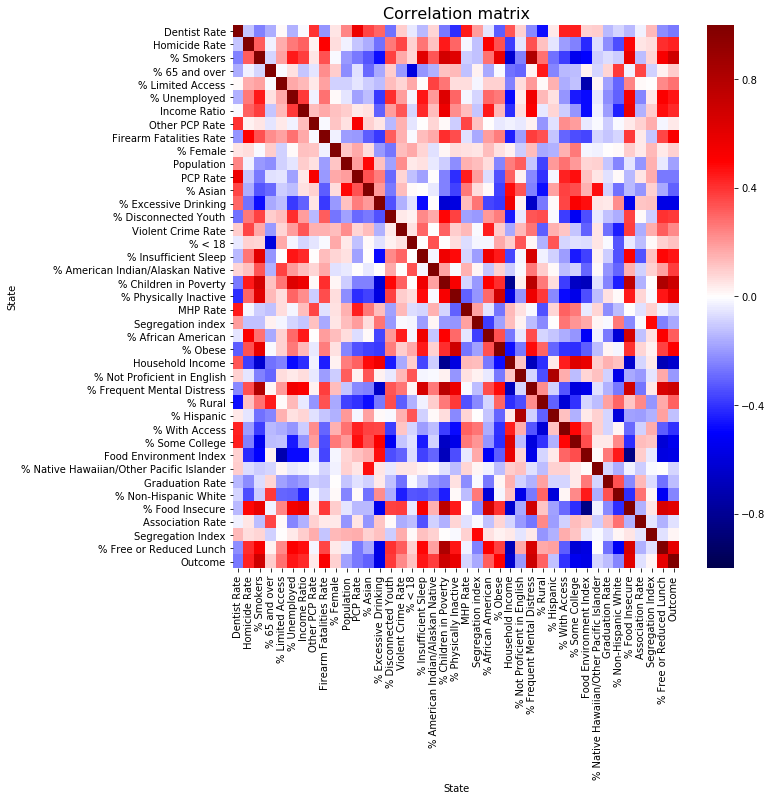

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(X.assign(Outcome = y).corr().round(2), cmap = 'seismic',center=0,vmin=-1,vmax=1, annot = False).set_title('Correlation matrix', fontsize = 16)


# Feature Selection

## Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 600,max_features='sqrt',max_depth=20,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_valid, y_valid)))

R^2 Training Score: 0.97 
OOB Score: 0.79 
R^2 Validation Score: 0.79


### note model is overfit to training data

In [208]:
pd.DataFrame({'feature': X_train.columns,'feature_importance': rf.feature_importances_}) \
           .sort_values('feature_importance', ascending = False).head()


,feature,feature_importance
11,% Children in Poverty,0.102819
33,% Frequent Mental Distress,0.090382
12,Household Income,0.085306
39,% Smokers,0.079536
32,% Food Insecure,0.047111


In [15]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge(alpha=.01, normalize=True)

ridgeReg.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(ridgeReg.score(X_train, y_train),
                                                                                    ridgeReg.score(X_valid, y_valid)))

R^2 Training Score: 0.73 
R^2 Validation Score: 0.72


## Drop Column

In [28]:
clone_forrest = clone(rf)
clone_forrest.random_state = 42
clone_forrest.fit(X_train, y_train)
benchmark_score = clone_forrest.score(X_train, y_train)
importances = []

for col in X_train.columns:
    clone_forrest = clone(rf)
    clone_forrest.random_state = 42
    clone_forrest.fit(X_train.drop(col, axis = 1), y_train)
    drop_col_score = clone_forrest.score(X_train.drop(col, axis = 1), y_train)
    importances.append(benchmark_score - drop_col_score)

In [30]:
pd.DataFrame({'feature': X_train.columns,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True).head()

,feature,feature_importance
0,Firearm Fatalities Rate,0.001455
1,% American Indian/Alaskan Native,0.001153
2,% Not Proficient in English,0.000730
3,Violent Crime Rate,0.000694
4,% Excessive Drinking,0.000678


## K Best 

In [50]:
from sklearn import feature_selection

model = feature_selection.SelectKBest(score_func=feature_selection.f_regression,\
                                      k=5)

importances_f = model.fit(X_train, y_train)

model = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_regression,\
                                      k=5)

importances_mi = model.fit(X_train, y_train)


In [54]:
pd.DataFrame({'feature': X_train.columns,
                       'feature_importance (fscore)': importances_f.scores_}) \
           .sort_values('feature_importance (fscore)', ascending = False) \
           .reset_index(drop = True).head()

,feature,feature_importance (fscore)
0,% Children in Poverty,6048.655061
1,% Frequent Mental Distress,5850.533601
2,% Smokers,5457.416120
3,Household Income,4193.695030
4,% Food Insecure,3590.679227


In [56]:
pd.DataFrame({'feature': X_train.columns,
                       'feature_importance (mutual info)': importances_mi.scores_}) \
           .sort_values('feature_importance (mutual info)', ascending = False) \
           .reset_index(drop = True).head()

,feature,feature_importance (mutual info)
0,% Children in Poverty,0.415240
1,Household Income,0.383179
2,% Frequent Mental Distress,0.373829
3,% Smokers,0.353831
4,% Free or Reduced Lunch,0.328970
